# Stereoisomer testing on ptree - enantiomers

## Importing section

In [1]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
import sys

sys.path.append("../../../../")

from ptgnn.features.chienn.molecule3d import smiles_to_3d_mol
from ptgnn.features.chienn.mol_to_data import mol_to_data
from ptgnn.transform import edge_graph_transform, vertex_graph_transform
from ptgnn.model.modules.ptree.complex_ptree_layer import ComplexPtreeLayer

## Define SMILES strings

In [2]:
smiles_list = [
    "C(Br)(Cl)F",
    "[C@H](Br)(Cl)F",
    "[C@H](Br)(Cl)F",
    "[C@@H](Br)(Cl)F",
]

## Visualize and confirm stereomer classification (E/Z)

In [3]:
def showAndChiral(smiles):
    mol = Chem.MolFromSmiles(smiles)
    display(mol)
    print(AllChem.FindMolChiralCenters(mol, includeUnassigned=True))
    for bond in mol.GetBonds():
        if bond.GetBondType() == Chem.rdchem.BondType.DOUBLE:
            print("Bond", bond.GetIdx(), "stereo:", bond.GetStereo())

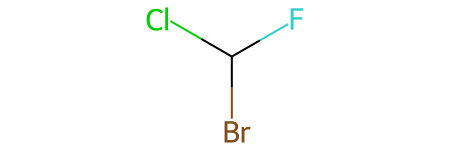

[(0, '?')]


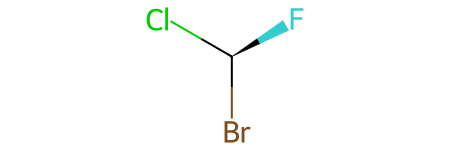

[(0, 'R')]


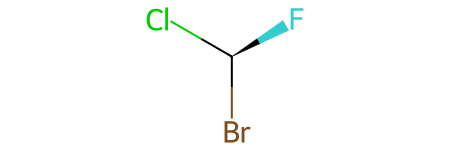

[(0, 'R')]


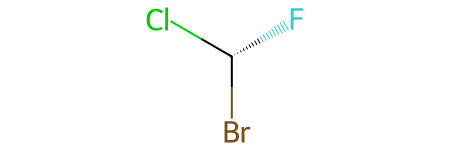

[(0, 'S')]


In [4]:
for smile in smiles_list:
    showAndChiral(smile)

##  Convert to (edge) graph with ptree

In [5]:
# get molecules
mol_list = [
    smiles_to_3d_mol(
        smiles,
        max_number_of_attempts=100,
        max_number_of_atoms=100
    )
    for smiles in smiles_list
]

In [6]:
data_list = [
    mol_to_data(mol)
    for mol in mol_list
]

In [7]:
data_list = [
    edge_graph_transform(
        data,
        transformation_mode="permutation_tree",
        mol=mol,
        transformation_parameters={
            'k':  3,
            'tetrahedral_chiral': True,
            'chiral_center_selective': True,
            'chiral_center_select_potential': False,
        }
    )
    for data, mol in zip(data_list, mol_list)
]

In [8]:
d = data_list[0]
display(d.ptree, d.initial_map)
for i in range(d.num_layer):
    display(f"layer: {i}")
    display(d[f"layer{i}_order_matrix"], d[f"layer{i}_type_mask"], d[f"layer{i}_pooling"])

['{"S": [0, 1]}',
 '{"S": [1, 0, {"P": [3, 7, 5]}]}',
 '{"S": [2, 3, {"P": [0, 5, 7]}]}',
 '{"S": [3, 2]}',
 '{"S": [4, 5, {"P": [0, 7, 3]}]}',
 '{"S": [5, 4]}',
 '{"S": [6, 7, {"P": [0, 3, 5]}]}',
 '{"S": [7, 6]}']

tensor([0, 1, 1, 0, 3, 7, 5, 2, 3, 0, 5, 7, 3, 2, 4, 5, 0, 7, 3, 5, 4, 6, 7, 0,
        3, 5, 7, 6])

'layer: 0'

[[tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
           18, 19, 20, 21, 22, 23, 24, 25, 26, 27],
          [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
           -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
          [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
           -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]], dtype=torch.int32)]]

[[tensor([0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
          1, 1, 0, 0])]]

[[tensor([ 0,  1,  2,  3,  4,  4,  4,  5,  6,  7,  7,  7,  8,  9, 10, 11, 12, 12,
          12, 13, 14, 15, 16, 17, 17, 17, 18, 19])]]

'layer: 1'

[[tensor([[ 0, -1,  2, -1, -1,  5, -1, -1,  8, -1, 10, -1, -1, 13, -1, 15, -1, -1,
           18, -1],
          [ 1, -1,  3, -1, -1,  6, -1, -1,  9, -1, 11, -1, -1, 14, -1, 16, -1, -1,
           19, -1],
          [-1, -1,  4, -1, -1,  7, -1, -1, -1, -1, 12, -1, -1, -1, -1, 17, -1, -1,
           -1, -1]], dtype=torch.int32)]]

[[tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])]]

[[tensor([0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 4, 5, 5, 6, 6, 6, 7, 7])]]

In [9]:
for data in data_list:
    print(data)
    print(data.ptree)

Data(x=[8, 93], edge_index=[2, 20], edge_attr=[20, 57], pos=[8, 6], parallel_node_index=[8], circle_index=[8], ptree=[8], initial_map=[28], layer0_order_matrix=[1], layer0_type_mask=[1], layer0_pooling=[1], num_layer=2, layer1_order_matrix=[1], layer1_type_mask=[1], layer1_pooling=[1])
['{"S": [0, 1]}', '{"S": [1, 0, {"P": [3, 7, 5]}]}', '{"S": [2, 3, {"P": [0, 5, 7]}]}', '{"S": [3, 2]}', '{"S": [4, 5, {"P": [0, 7, 3]}]}', '{"S": [5, 4]}', '{"S": [6, 7, {"P": [0, 3, 5]}]}', '{"S": [7, 6]}']
Data(x=[8, 93], edge_index=[2, 20], edge_attr=[20, 57], pos=[8, 6], parallel_node_index=[8], circle_index=[8], ptree=[8], initial_map=[28], layer0_order_matrix=[1], layer0_type_mask=[1], layer0_pooling=[1], num_layer=2, layer1_order_matrix=[1], layer1_type_mask=[1], layer1_pooling=[1])
['{"S": [0, 1]}', '{"S": [1, 0, {"Z": [3, 7, 5]}]}', '{"S": [2, 3, {"Z": [0, 5, 7]}]}', '{"S": [3, 2]}', '{"S": [4, 5, {"Z": [0, 7, 3]}]}', '{"S": [5, 4]}', '{"S": [6, 7, {"Z": [0, 3, 5]}]}', '{"S": [7, 6]}']
Data(x=[

## Create Model

In [10]:
from ptgnn.model.modules.ptree.advanced_tree_layer import AdvancedPermutationTreeLayer

k = 3

model = AdvancedPermutationTreeLayer(
    hidden_dim=93,
    k=k
)

## Create batches

In [11]:
from ptgnn.loading.collate import permutation_tree_collation

batch_list = [
    permutation_tree_collation([data])
    for data in data_list
]

In [12]:
for idx, batch in enumerate(batch_list):
    display(f"Batch: {idx}")
    display(batch.ptree)
    display(batch.initial_map)
    for layer_idx in range(batch.num_layer):
        display(f"Layer: {layer_idx}")
        display(
            batch[f"layer{layer_idx}_order_matrix"],
            batch[f"layer{layer_idx}_type_mask"],
            batch[f"layer{layer_idx}_pooling"]
        )

'Batch: 0'

['{"S": [0, 1]}',
 '{"S": [1, 0, {"P": [3, 7, 5]}]}',
 '{"S": [2, 3, {"P": [0, 5, 7]}]}',
 '{"S": [3, 2]}',
 '{"S": [4, 5, {"P": [0, 7, 3]}]}',
 '{"S": [5, 4]}',
 '{"S": [6, 7, {"P": [0, 3, 5]}]}',
 '{"S": [7, 6]}']

tensor([0, 1, 1, 0, 3, 7, 5, 2, 3, 0, 5, 7, 3, 2, 4, 5, 0, 7, 3, 5, 4, 6, 7, 0,
        3, 5, 7, 6])

'Layer: 0'

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]], dtype=torch.int32)

tensor([0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
        1, 1, 0, 0])

tensor([ 0,  1,  2,  3,  4,  4,  4,  5,  6,  7,  7,  7,  8,  9, 10, 11, 12, 12,
        12, 13, 14, 15, 16, 17, 17, 17, 18, 19])

'Layer: 1'

tensor([[ 0, -1,  2, -1, -1,  5, -1, -1,  8, -1, 10, -1, -1, 13, -1, 15, -1, -1,
         18, -1],
        [ 1, -1,  3, -1, -1,  6, -1, -1,  9, -1, 11, -1, -1, 14, -1, 16, -1, -1,
         19, -1],
        [-1, -1,  4, -1, -1,  7, -1, -1, -1, -1, 12, -1, -1, -1, -1, 17, -1, -1,
         -1, -1]], dtype=torch.int32)

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

tensor([0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 4, 5, 5, 6, 6, 6, 7, 7])

'Batch: 1'

['{"S": [0, 1]}',
 '{"S": [1, 0, {"Z": [3, 7, 5]}]}',
 '{"S": [2, 3, {"Z": [0, 5, 7]}]}',
 '{"S": [3, 2]}',
 '{"S": [4, 5, {"Z": [0, 7, 3]}]}',
 '{"S": [5, 4]}',
 '{"S": [6, 7, {"Z": [0, 3, 5]}]}',
 '{"S": [7, 6]}']

tensor([0, 1, 1, 0, 3, 7, 5, 2, 3, 0, 5, 7, 3, 2, 4, 5, 0, 7, 3, 5, 4, 6, 7, 0,
        3, 5, 7, 6])

'Layer: 0'

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27],
        [-1, -1, -1, -1,  5,  6,  4, -1, -1, 10, 11,  9, -1, -1, -1, -1, 17, 18,
         16, -1, -1, -1, -1, 24, 25, 23, -1, -1],
        [-1, -1, -1, -1,  6,  4,  5, -1, -1, 11,  9, 10, -1, -1, -1, -1, 18, 16,
         17, -1, -1, -1, -1, 25, 23, 24, -1, -1]], dtype=torch.int32)

tensor([0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2,
        2, 2, 0, 0])

tensor([ 0,  1,  2,  3,  4,  4,  4,  5,  6,  7,  7,  7,  8,  9, 10, 11, 12, 12,
        12, 13, 14, 15, 16, 17, 17, 17, 18, 19])

'Layer: 1'

tensor([[ 0, -1,  2, -1, -1,  5, -1, -1,  8, -1, 10, -1, -1, 13, -1, 15, -1, -1,
         18, -1],
        [ 1, -1,  3, -1, -1,  6, -1, -1,  9, -1, 11, -1, -1, 14, -1, 16, -1, -1,
         19, -1],
        [-1, -1,  4, -1, -1,  7, -1, -1, -1, -1, 12, -1, -1, -1, -1, 17, -1, -1,
         -1, -1]], dtype=torch.int32)

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

tensor([0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 4, 5, 5, 6, 6, 6, 7, 7])

'Batch: 2'

['{"S": [0, 1]}',
 '{"S": [1, 0, {"Z": [3, 7, 5]}]}',
 '{"S": [2, 3, {"Z": [0, 5, 7]}]}',
 '{"S": [3, 2]}',
 '{"S": [4, 5, {"Z": [0, 7, 3]}]}',
 '{"S": [5, 4]}',
 '{"S": [6, 7, {"Z": [0, 3, 5]}]}',
 '{"S": [7, 6]}']

tensor([0, 1, 1, 0, 3, 7, 5, 2, 3, 0, 5, 7, 3, 2, 4, 5, 0, 7, 3, 5, 4, 6, 7, 0,
        3, 5, 7, 6])

'Layer: 0'

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27],
        [-1, -1, -1, -1,  5,  6,  4, -1, -1, 10, 11,  9, -1, -1, -1, -1, 17, 18,
         16, -1, -1, -1, -1, 24, 25, 23, -1, -1],
        [-1, -1, -1, -1,  6,  4,  5, -1, -1, 11,  9, 10, -1, -1, -1, -1, 18, 16,
         17, -1, -1, -1, -1, 25, 23, 24, -1, -1]], dtype=torch.int32)

tensor([0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2,
        2, 2, 0, 0])

tensor([ 0,  1,  2,  3,  4,  4,  4,  5,  6,  7,  7,  7,  8,  9, 10, 11, 12, 12,
        12, 13, 14, 15, 16, 17, 17, 17, 18, 19])

'Layer: 1'

tensor([[ 0, -1,  2, -1, -1,  5, -1, -1,  8, -1, 10, -1, -1, 13, -1, 15, -1, -1,
         18, -1],
        [ 1, -1,  3, -1, -1,  6, -1, -1,  9, -1, 11, -1, -1, 14, -1, 16, -1, -1,
         19, -1],
        [-1, -1,  4, -1, -1,  7, -1, -1, -1, -1, 12, -1, -1, -1, -1, 17, -1, -1,
         -1, -1]], dtype=torch.int32)

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

tensor([0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 4, 5, 5, 6, 6, 6, 7, 7])

'Batch: 3'

['{"S": [0, 1]}',
 '{"S": [1, 0, {"Z": [3, 5, 7]}]}',
 '{"S": [2, 3, {"Z": [0, 7, 5]}]}',
 '{"S": [3, 2]}',
 '{"S": [4, 5, {"Z": [0, 3, 7]}]}',
 '{"S": [5, 4]}',
 '{"S": [6, 7, {"Z": [0, 5, 3]}]}',
 '{"S": [7, 6]}']

tensor([0, 1, 1, 0, 3, 5, 7, 2, 3, 0, 7, 5, 3, 2, 4, 5, 0, 3, 7, 5, 4, 6, 7, 0,
        5, 3, 7, 6])

'Layer: 0'

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27],
        [-1, -1, -1, -1,  5,  6,  4, -1, -1, 10, 11,  9, -1, -1, -1, -1, 17, 18,
         16, -1, -1, -1, -1, 24, 25, 23, -1, -1],
        [-1, -1, -1, -1,  6,  4,  5, -1, -1, 11,  9, 10, -1, -1, -1, -1, 18, 16,
         17, -1, -1, -1, -1, 25, 23, 24, -1, -1]], dtype=torch.int32)

tensor([0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2,
        2, 2, 0, 0])

tensor([ 0,  1,  2,  3,  4,  4,  4,  5,  6,  7,  7,  7,  8,  9, 10, 11, 12, 12,
        12, 13, 14, 15, 16, 17, 17, 17, 18, 19])

'Layer: 1'

tensor([[ 0, -1,  2, -1, -1,  5, -1, -1,  8, -1, 10, -1, -1, 13, -1, 15, -1, -1,
         18, -1],
        [ 1, -1,  3, -1, -1,  6, -1, -1,  9, -1, 11, -1, -1, 14, -1, 16, -1, -1,
         19, -1],
        [-1, -1,  4, -1, -1,  7, -1, -1, -1, -1, 12, -1, -1, -1, -1, 17, -1, -1,
         -1, -1]], dtype=torch.int32)

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

tensor([0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 4, 5, 5, 6, 6, 6, 7, 7])

In [13]:
# compare output
display(np.array(
    [
        [
            (batch_list[i].x == batch_list[j].x).all()
            for j in range(len(batch_list))
        ]
        for i in range(len(batch_list))
    ]
))

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

## Put batches through model

In [14]:
out_list = [
    model(batch)
    for batch in batch_list
]

In [15]:
out_list

[tensor([[ 2.7440e-01, -1.2946e-01, -4.3505e-02, -5.5627e-02,  1.7508e-01,
           1.1411e-01,  2.6857e-01, -4.9428e-02,  1.3861e-02,  6.6328e-02,
           6.8950e-02, -3.7031e-02,  4.7839e-02, -9.1075e-02, -1.7589e-03,
          -3.4580e-03,  3.4356e-03,  1.9196e-02, -7.3885e-02, -2.6100e-01,
           2.4887e-01,  2.4029e-01,  1.6990e-01,  1.6264e-01, -1.5248e-01,
          -1.3643e-02, -1.4979e-01, -1.3834e-01,  1.2074e-01,  5.4560e-03,
          -7.8808e-02,  1.2968e-01,  3.4786e-02,  9.1218e-02,  1.9803e-02,
           1.3331e-01, -5.5900e-02, -7.5729e-02, -1.2959e-01, -2.9440e-02,
          -9.2062e-02, -1.1979e-01,  6.0882e-02,  2.7615e-01, -5.8699e-02,
           1.7437e-01, -9.0318e-03,  1.4238e-01,  1.3897e-01,  2.2119e-01,
          -1.2710e-01,  6.6568e-02, -2.9088e-02,  1.0537e-01, -2.9583e-01,
          -2.4283e-02, -1.7257e-02,  1.2868e-01,  1.9428e-01, -1.7053e-01,
           9.5739e-02,  8.4496e-02, -1.4396e-01, -5.9220e-02,  1.0408e-01,
           1.3499e-01, -3

## Compare batches

In [16]:
# compare output
display(np.array(
    [
        [
            (out_list[i] == out_list[j]).all()
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
))

array([[ True, False, False, False],
       [False,  True,  True, False],
       [False,  True,  True, False],
       [False, False, False,  True]])

In [17]:
# compare sum pooled version itself
display(np.array(
    [
        [
            out_list[i].sum().item() - out_list[j].sum().item()
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
) == 0)

array([[ True, False, False, False],
       [False,  True,  True, False],
       [False,  True,  True, False],
       [False, False, False,  True]])

In [18]:
# compare output
display(np.array(
    [
        [
            (out_list[i] - out_list[j]).detach().abs().sum()
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
))

array([[ 0.        , 47.859818  , 47.859818  , 47.856377  ],
       [47.859818  ,  0.        ,  0.        ,  0.42052308],
       [47.859818  ,  0.        ,  0.        ,  0.42052308],
       [47.856377  ,  0.42052308,  0.42052308,  0.        ]],
      dtype=float32)